In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss, auc, roc_curve, roc_auc_score, accuracy_score, precision_recall_curve, confusion_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
%matplotlib inline

In [83]:
##Load data for final model
data = pd.read_csv('../ult_sign_scrape/race_master/master_database_fe4.csv')
##Load Brazos Bend 100 data for model check
cvdata = pd.read_csv('../ult_sign_scrape/race_master/BB2015.csv')

In [84]:
data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1,age,gender,participant_id,runner_rank,status,race_id,race_name,Season,Metro_area,WL_SO,Entry_fee,PPM,Age_Rank,Gender_Rank,Total_races,Success_rate
0,0,0,0,26,M,7148,88.39,1,11470,Bear,3,0,1,1,2.5,0.7174,0.6806,23.0,0.956522
1,1,1,1,33,M,221721,90.00,1,11470,Bear,3,0,1,1,2.5,0.8132,0.6987,9.0,0.888889
2,2,2,2,43,M,20020,83.63,1,11470,Bear,3,0,1,1,2.5,0.8272,0.7145,17.0,0.882353
3,3,3,3,36,M,25441,73.22,1,11470,Bear,3,0,1,1,2.5,0.8995,0.8957,14.0,0.857143
4,4,4,4,33,M,22562,87.77,1,11470,Bear,3,0,1,1,2.5,0.6807,0.6522,7.0,1.000000


In [85]:
##Clean data by dropping extraneous columns
cleaned_data = data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
##Clean BB100
bb100 = cvdata.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
##Second stage of cleaning by removing na values from dataframe
cleaned_data = cleaned_data.dropna()
cleaned_data['success_metric'] = cleaned_data['Total_races'] * cleaned_data['Success_rate']

In [92]:
(73.721818 + 79.389167 + 73.084667 + 74.070278 + 74.434483 + 73.750921 + 73.533558 + )

14.259259166666666

In [155]:
cleaned_data.groupby(['age']).mean()[0:18]['runner_rank'].mean()

70.38512305163684

In [37]:
##Create gender dummy variables for model
gender_dummies = pd.get_dummies(cleaned_data.gender, prefix='gender')
cleaned_data = cleaned_data.join(gender_dummies)
bbgender_dummies = pd.get_dummies(bb100.gender, prefix='gender')
bb100 = bb100.join(bbgender_dummies)

In [38]:
##Consolidate all starts (code DNF with finishers) for modeling
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded
 
print 'Before Coding:'
print pd.value_counts(cleaned_data["status"])
cleaned_data["status_coded"] = coding(cleaned_data["status"], {'1':0,'2':0, '3':1})
cleaned_data['DNF_DNS_coded'] = coding(cleaned_data["status"], {'1':1,'2':0, '3':0})
##BB100 CV data:
bb100["status_coded"] = coding(bb100["status"], {'1':0,'2':0, '3':1})
bb100['DNF_DNS_coded'] = coding(bb100["status"], {'1':1,'2':0, '3':0})
print '\nAfter Coding:'
print pd.value_counts(cleaned_data["status_coded"])
print '\nAfter DNF Coding:'
print pd.value_counts(cleaned_data["DNF_DNS_coded"])
status_coded = cleaned_data.drop(['status'], axis=1)
status_DNF = cleaned_data.copy()
status_DNF = cleaned_data.drop(['status', 'status_coded'], axis=1)
bb100_coded = bb100.drop(['status'], axis=1)

Before Coding:
1    6203
2    3809
3     498
Name: status, dtype: int64

After Coding:
0    10012
1      498
Name: status_coded, dtype: int64

After DNF Coding:
1    6203
0    4307
Name: DNF_DNS_coded, dtype: int64


In [39]:
bb100_coded.tail()

,age,gender,participant_id,runner_rank,race_id,race_name,Season,Metro_area,WL_SO,Entry_fee,PPM,Age_Rank,Gender_Rank,Total_races,Success_rate,gender_F,gender_M,status_coded,DNF_DNS_coded
99,42,M,381672,66.53,31333,BB,4,1,0,0,1.9,0.0000,0.2562,1.0,1.000,0.0,1.0,1,0
100,50,M,215892,54.38,31333,BB,4,1,0,0,1.9,0.6605,0.6653,5.0,0.800,0.0,1.0,1,0
101,30,F,311007,83.48,31333,BB,4,1,0,0,1.9,0.7550,0.5721,0.0,0.000,1.0,0.0,1,0
102,38,M,749574,52.83,31333,BB,4,1,0,0,1.9,0.0000,0.0000,0.0,0.000,0.0,1.0,1,0
103,52,F,775499,47.53,31333,BB,4,1,0,0,1.9,0.9140,0.7973,8.0,0.875,1.0,0.0,1,0


In [40]:
##Set response variable for coded dataframe
y_DNS = status_coded.pop('status_coded')
##Set response variable for uncoded dataframe
y_DNF = cleaned_data.pop('status')
##Set response variable for DNF/DNS to finishers DF
y_Finish = cleaned_data.pop('DNF_DNS_coded')
##Set cross validation response for BB100
y_BB100 = bb100_coded.pop('status_coded')
##Set response variable for DNF/DNS to finishers DF for BB100
y_Finish_BB100 = bb100_coded.pop('DNF_DNS_coded')

In [42]:
##Set predictors for coded dataframe
codedX = status_coded.drop(['gender', 'participant_id', 'race_name', 'race_id'\
                 , 'gender_M', 'DNF_DNS_coded'], axis=1)
##Set predictors for uncoded dataframe
uncodedX = cleaned_data.drop(['gender', 'participant_id', 'race_name', 'race_id'\
                 , 'gender_M'], axis=1)
##Set predictors for predicting DNF/DNS to finishers
finish_model = cleaned_data.drop(['gender', 'participant_id', 'race_name', 'race_id'\
                 , 'gender_M', 'status_coded', 'success_metric'], axis=1)
##Set predictors for BB100 cross validation
BB100X = bb100_coded.drop(['gender', 'participant_id', 'race_name', 'race_id'\
                 , 'gender_M'], axis=1)
##Set finisher predictors for BB100 cross validation
BB100X_Finish = bb100_coded.drop(['gender', 'participant_id', 'race_name', 'race_id'\
                 , 'gender_M'], axis=1)

In [43]:
#BB100X_Finish.head()
finish_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10510 entries, 0 to 10509
Data columns (total 12 columns):
age             10510 non-null int64
runner_rank     10510 non-null float64
Season          10510 non-null int64
Metro_area      10510 non-null int64
WL_SO           10510 non-null int64
Entry_fee       10510 non-null int64
PPM             10510 non-null float64
Age_Rank        10510 non-null float64
Gender_Rank     10510 non-null float64
Total_races     10510 non-null float64
Success_rate    10510 non-null float64
gender_F        10510 non-null float64
dtypes: float64(7), int64(5)
memory usage: 1.0 MB


In [44]:
##Create test/train splits for both datasets
##coded dataframe
cX_train, cX_test, cy_train, cy_test = train_test_split(codedX, y_DNS, test_size=0.3)
##uncoded dataframe
uX_train, uX_test, uy_train, uy_test = train_test_split(uncodedX, y_DNF, test_size=0.3)
##finisher dataframe
fX_train, fX_test, fy_train, fy_test = train_test_split(finish_model, y_Finish, test_size=0.3)

In [45]:
BB100X.info(), codedX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 12 columns):
age             104 non-null int64
runner_rank     104 non-null float64
Season          104 non-null int64
Metro_area      104 non-null int64
WL_SO           104 non-null int64
Entry_fee       104 non-null int64
PPM             104 non-null float64
Age_Rank        104 non-null float64
Gender_Rank     104 non-null float64
Total_races     104 non-null float64
Success_rate    104 non-null float64
gender_F        104 non-null float64
dtypes: float64(7), int64(5)
memory usage: 9.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10510 entries, 0 to 10509
Data columns (total 13 columns):
age               10510 non-null int64
runner_rank       10510 non-null float64
Season            10510 non-null int64
Metro_area        10510 non-null int64
WL_SO             10510 non-null int64
Entry_fee         10510 non-null int64
PPM               10510 non-null float64
Age_Rank          10510 n

(None, None)

# Logistic Regression Modeling

In [228]:
##coded dataframe
cLR = LR(C=10)
cLR.fit(cX_train, cy_train)
cLRp = cLR.predict_proba(cX_test)
cLRpr = cLR.predict(cX_test)
print log_loss(cy_test, cLRp)
print roc_auc_score(cy_test, cLRp[:,1])
print confusion_matrix(cy_test, cLRpr)

0.184121759271
0.618828811449
[[3001    0]
 [ 152    0]]


In [229]:
##uncoded dataframe
uLR = LR(C=10)
uLR.fit(uX_train, uy_train)
uLRp = uLR.predict_proba(uX_test)
uLRa = uLR.predict(uX_test)
print log_loss(uy_test, uLRp)
print accuracy_score(uy_test, uLRa)

0.595052065254
0.669203932762


In [230]:
##Finisher dataframe
fLR = LR(C=100, penalty='l2', solver='newton-cg')
fLR.fit(fX_train, fy_train)
fLRp = fLR.predict_proba(fX_test)
fLRpr = fLR.predict(fX_test)
print log_loss(fy_test, fLRp)
print roc_auc_score(fy_test, fLRp[:,1])
print confusion_matrix(cy_test, cLRpr)

0.631364842041
0.667350019074
[[3001    0]
 [ 152    0]]


In [231]:
##Brazos Bend Cross Validation
##coded dataframe
cLR = LR(C=10)
cLR.fit(cX_train, cy_train)
cLRpb = cLR.predict_proba(BB100X)
cLRpr = cLR.predict(BB100X)
print log_loss(y_BB100, cLRpb)
print roc_auc_score(y_BB100, cLRpb[:,1])
print confusion_matrix(y_BB100, cLRpr)

0.282646878537
0.55078125
[[96  0]
 [ 8  0]]


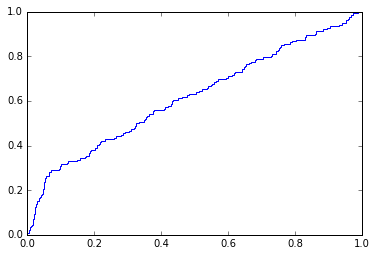

In [232]:
##ROC curve
fpr, tpr, thresholds = roc_curve(cy_test, cLRp[:,1]) 
plt.plot(fpr, tpr)
plt.show()

# Random Forest

In [254]:
##coded dataframe
cRF = RFC(n_estimators=1000, criterion='gini', random_state=1, n_jobs=2)
cRF.fit(cX_train, cy_train)
cRFp = cRF.predict_proba(cX_test)
cRFpr = cRF.predict(cX_test)

print log_loss(cy_test, cRFp)
print roc_auc_score(cy_test, cRFp[:,1])
print confusion_matrix(cy_test, cRFpr)

0.204624113361
0.652396569565
[[2995    6]
 [ 152    0]]


In [236]:
# cRF = RFC(n_estimators=1000, criterion='gini', random_state=1, n_jobs=2)
# cRF.fit(cX_train, cy_train)
cRFpb = cRF.predict_proba(BB100X)
cRFpr = cRF.predict(BB100X)

print log_loss(y_BB100, cRFpb)
print roc_auc_score(y_BB100, cRFpb[:,1])
print confusion_matrix(y_BB100, cRFpr)

0.323268680046
0.626302083333
[[96  0]
 [ 8  0]]


In [237]:
positive = []
negative = []
for each in cRFp[:,1]:
    if each > 0.002:
        positive.append(1)
        negative.append(0)
    else:
        positive.append(0)
        negative.append(1)
confusion_matrix(cy_test, negative)   

ValueError: Found input variables with inconsistent numbers of samples: [3153, 104]

In [238]:
##uncoded dataframe
uRF = RFC(n_estimators=1000, criterion='gini', random_state=1, n_jobs=2)
uRF.fit(uX_train, uy_train)
uRFp = uRF.predict_proba(uX_test)
uRFa = uRF.predict(uX_test)
print log_loss(uy_test, uRFp)
print accuracy_score(uy_test, uRFa)
print confusion_matrix(uy_test, uRFa)

0.596672954424
0.677767205836
[[1522  300    0]
 [ 716  461    0]
 [   0    0  154]]


In [30]:
fX_train.head()

,age,runner_rank,Season,Metro_area,WL_SO,Entry_fee,PPM,Age_Rank,Gender_Rank,Total_races,Success_rate,gender_F
3894,46,76.29,3,1,0,1,2.65,0.0000,0.0000,1.0,0.000000,1.0
480,58,74.09,3,0,1,1,2.50,0.0000,0.6189,1.0,1.000000,0.0
7007,45,56.51,2,1,1,1,2.75,0.8750,0.8446,1.0,1.000000,1.0
9573,32,74.83,1,1,1,1,2.50,0.5907,0.5586,5.0,1.000000,0.0
9927,53,58.57,3,0,1,1,2.50,0.7459,0.6674,9.0,0.777778,0.0


In [240]:
##Finisher dataframe
fRF = RFC(n_estimators=500, criterion='gini', random_state=1, n_jobs=2)
fRF.fit(fX_train, fy_train)
fRFp = fRF.predict_proba(fX_test)
fRFpr = fRF.predict(fX_test)

print log_loss(fy_test, fRFp)
print roc_auc_score(fy_test, fRFp[:,1])
print confusion_matrix(fy_test, fRFpr)

0.628582381905
0.676556617074
[[ 576  729]
 [ 373 1475]]


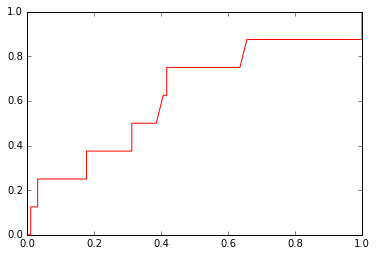

In [252]:
##ROC curve
fpr, tpr, thresholds = roc_curve(y_BB100, cRFpb[:,1]) 
labels = ['fpr', 'tpr']
RFP = plt.plot(fpr, tpr, 'r', label='Random Forest')


# Gradient Boosted Classifier

In [22]:
##coded dataframe
cGBC = GBC(n_estimators=10000, max_depth=5, learning_rate=0.001)
cGBC.fit(cX_train, cy_train)
cGBCp = cGBC.predict_proba(cX_test)
cGBCpr = cGBC.predict(cX_test)
print log_loss(cy_test, cGBCp)
print roc_auc_score(cy_test, cGBCp[:,1])
print confusion_matrix(cy_test, cGBCpr)
print accuracy_score(cy_test, cGBCpr)

0.183990558482
0.674663848541
[[2994   11]
 [ 145    3]]
0.950523311132


In [31]:
##BB100 Cross validation data
# cGBC = GBC(n_estimators=10000, max_depth=5, learning_rate=0.001)
# cGBC.fit(cX_train, cy_train)
cGBCpb = cGBC.predict_proba(BB100X)
cGBCpr = cGBC.predict(BB100X)
print log_loss(y_BB100, cGBCpb)
print roc_auc_score(y_BB100, cGBCpb[:,1])
print confusion_matrix(y_BB100, cGBCpr)

ValueError: Number of features of the model must match the input. Model n_features is 13 and input n_features is 12 

In [246]:
##uncoded dataframe
uGBC = GBC(n_estimators=50, max_depth=4, learning_rate=0.1)
uGBC.fit(uX_train, uy_train)
uGBCp = uGBC.predict_proba(uX_test)
uGBCa = uGBC.predict(uX_test)
print log_loss(uy_test, uGBCp)
print accuracy_score(uy_test, uGBCa)

0.579985184229
0.690453536315


In [159]:
##Finisher dataframe
# fGBC = GBC(n_estimators=1000, max_depth=8, learning_rate=0.01)
# fGBC.fit(fX_train, fy_train)
# fGBCp = fGBC.predict_proba(fX_test)
# fGBCpr = fGBC.predict(fX_test)
# print log_loss(fy_test, fGBCp)
# print roc_auc_score(fy_test, fGBCp[:,1])
# print confusion_matrix(fy_test, fGBCpr)
# print accuracy_score(fy_test, fGBCpr)
fGBCp, fy_test


(array([[ 0.27482046,  0.72517954],
        [ 0.29810954,  0.70189046],
        [ 0.43556611,  0.56443389],
        ..., 
        [ 0.37481883,  0.62518117],
        [ 0.20952632,  0.79047368],
        [ 0.63109716,  0.36890284]]), 9647     1
 422      1
 4682     1
 5388     0
 3346     1
 9195     1
 7651     0
 8937     1
 543      1
 4900     0
 4486     0
 7354     1
 5920     1
 5439     0
 4591     1
 4276     1
 9397     1
 1611     0
 702      1
 2473     0
 2664     1
 353      1
 7631     0
 3928     0
 7925     1
 4814     1
 7717     1
 7661     0
 169      1
 4042     1
         ..
 6809     1
 6144     1
 3837     0
 5789     0
 6637     1
 5376     0
 8385     1
 2343     1
 6726     0
 1234     0
 8682     1
 3679     1
 2600     1
 6110     1
 7255     1
 2930     1
 4553     0
 9336     0
 3341     1
 5677     1
 4686     1
 6746     0
 4660     1
 10148    1
 1261     1
 6044     1
 5594     0
 5936     1
 9174     0
 1717     0
 Name: DNF_DNS_coded, dtype: int64)

In [19]:
fX_train.shape

(7357, 12)

In [248]:
##BB100 Finishers
##Finisher dataframe
# fGBC = GBC(n_estimators=1000, max_depth=8, learning_rate=0.01)
# fGBC.fit(fX_train, fy_train)
fGBCpb = fGBC.predict_proba(BB100X_Finish)
fGBCpr = fGBC.predict(BB100X_Finish)
print log_loss(y_Finish_BB100, fGBCpb)
print roc_auc_score(y_Finish_BB100, fGBCpb[:,1])
print confusion_matrix(y_Finish_BB100, fGBCpr)
print accuracy_score(y_Finish_BB100, fGBCpr)


0.945481664487
0.410766045549
[[44 25]
 [30  5]]
0.471153846154


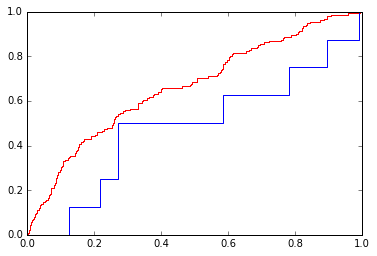

In [250]:
##ROC curve
fpr, tpr, thresholds = roc_curve(cy_test, cGBCp[:,1]) 
labels = ['fpr', 'tpr']
plt.plot(fpr, tpr, 'r')
fpr2, tpr2, thresholds = roc_curve(y_BB100, cGBCpb[:,1]) 
labels = ['fpr', 'tpr']
plt.plot(fpr, tpr, 'r')
plt.plot(fpr2, tpr2, 'b')
plt.show()

In [156]:
fpr, tpr, thresholds = roc_curve(cy_test, cRFp[:,1]) 
labels = ['fpr', 'tpr']
RFP = plt.plot(fpr, tpr, 'r', label='Random Forest')
fpr, tpr, thresholds = roc_curve(cy_test, cGBCp[:,1]) 
GBCP = plt.plot(fpr, tpr, 'b', label='Gradient Boosted Classifier')
fpr, tpr, thresholds = roc_curve(cy_test, cLRp[:,1]) 
LRP = plt.plot(fpr, tpr, 'k', label='Logistic Regression')
plt.ylabel('Pred Y, NS +$2.50')
plt.xlabel('Pred Y, S -Reputation')
plt.title('ROC curves for model selection')
plt.legend(['RF', 'GBC', 'LR'], loc=4)
plt.show()

NameError: name 'cRFp' is not defined

# Naive Bayes

In [256]:
##coded dataframe
cGNB = GaussianNB()
cGNB.fit(cX_train, cy_train)
cGNBp = cGNB.predict_proba(cX_test)
cGNBpr = cGNB.predict(cX_test)
print log_loss(cy_test, cGNBp)
print roc_auc_score(cy_test, cGNBp[:,1])
print confusion_matrix(cy_test, cGNBpr)
print accuracy_score(cy_test, cGNBpr)

0.360146885428
0.645221329732
[[2746  255]
 [ 107   45]]
0.885188709166


In [257]:
##BB100 CV data
cGNBpb = cGNB.predict_proba(BB100X)
cGNBpr = cGNB.predict(BB100X)
print log_loss(y_BB100, cGNBpb)
print roc_auc_score(y_BB100, cGNBpb[:,1])
print confusion_matrix(y_BB100, cGNBpr)

2.53247681437
0.55078125
[[ 5 91]
 [ 0  8]]


In [259]:
##uncoded dataframe
uGNB = GaussianNB()
uGNB.fit(uX_train, uy_train)
uGNBp = uGNB.predict_proba(uX_test)
uGNBpr = uGNB.predict(uX_test)
print log_loss(uy_test, uGNBp)
print confusion_matrix(uy_test, cGNBpr)
print accuracy_score(uy_test, cGNBpr)

0.73803557805


ValueError: Found input variables with inconsistent numbers of samples: [3153, 104]

In [260]:
##Finisher dataframe
fGNB = GaussianNB()
fGNB.fit(fX_train, fy_train)
fGNBp = fGNB.predict_proba(fX_test)
fGNBpr = fGNB.predict(fX_test)
print log_loss(fy_test, fGNBp)
print roc_auc_score(fy_test, fGNBp[:,1])
print confusion_matrix(fy_test, fGNBpr)
print accuracy_score(fy_test, fGNBpr)

0.76587416536
0.636809805775
[[ 480  825]
 [ 405 1443]]
0.609895337774


# Summary of Results

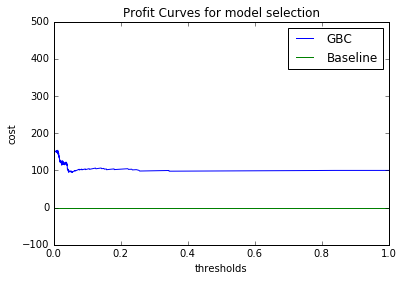

In [163]:
TPC = 250.
FPC = -100.
FNC = 0.
TNC = 100.
# fpr, tpr, thresholds = roc_curve(cy_test, cRFp[:,1]) 
labels = ['fpr', 'tpr']
# cost = (tpr * TPC) + ((1 - fpr) * TNC) + (fpr * FPC) + ((1 - tpr) * FNC)
# RFP = plt.plot(thresholds, cost, 'r', label='Random Forest')
fpr, tpr, thresholds = roc_curve(cy_test, cGBCp[:,1])
cost = (tpr * TPC) + ((1 - fpr) * TNC) + (fpr * FPC) + ((1 - tpr) * FNC)
GBcost = plt.plot(thresholds, cost, 'b', label='Gradient Boosted Classifier')
# fpr, tpr, thresholds = roc_curve(cy_test, cLRp[:,1]) 
# cost = (tpr * TPC) + ((1 - fpr) * TNC) + (fpr * FPC) + ((1 - tpr) * FNC)
# LRP = plt.plot(thresholds, cost, 'k', label='Logistic Regression')
plt.axhline(0, color='g')
plt.ylabel('cost')
plt.xlabel('thresholds')
plt.title('Profit Curves for model selection')
plt.axis([0, 1, -100, 500])
plt.legend(['GBC', 'Baseline'], loc=1)
plt.show()

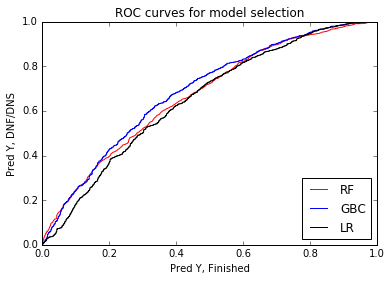

In [537]:
fpr, tpr, thresholds = roc_curve(fy_test, fRFp[:,1]) 
labels = ['fpr', 'tpr']
RFP = plt.plot(fpr, tpr, 'r', label='Random Forest')
fpr, tpr, thresholds = roc_curve(fy_test, fGBCp[:,1]) 
GBCP = plt.plot(fpr, tpr, 'b', label='Gradient Boosted Classifier')
fpr, tpr, thresholds = roc_curve(fy_test, fLRp[:,1]) 
LRP = plt.plot(fpr, tpr, 'k', label='Logistic Regression')
plt.ylabel('Pred Y, DNF/DNS')
plt.xlabel('Pred Y, Finished')
plt.title('ROC curves for model selection')
plt.legend(['RF', 'GBC', 'LR'], loc=4)
plt.show()

In [269]:
# TPC = 175.
# FPC = -250.
# FNC = 175.
# TNC = -250.
# fpr, tpr, thresholds = roc_curve(fy_test, fRFp[:,1]) 
# labels = ['fpr', 'tpr']
# cost = (tpr * TPC) + ((1 - fpr) * TNC) + (fpr * FPC) + ((1 - tpr) * FNC)
# RFP = plt.plot(thresholds, cost, 'r', label='Random Forest')
# fpr, tpr, thresholds = roc_curve(fy_test, fGBCp[:,1])
# cost = (tpr * TPC) + ((1 - fpr) * TNC) + (fpr * FPC) + ((1 - tpr) * FNC)
# GBcost = plt.plot(thresholds, cost, 'b', label='Gradient Boosted Classifier')
# fpr, tpr, thresholds = roc_curve(fy_test, fLRp[:,1]) 
# cost = (tpr * TPC) + ((1 - fpr) * TNC) + (fpr * FPC) + ((1 - tpr) * FNC)
# LRP = plt.plot(thresholds, cost, 'k', label='Logistic Regression')
# plt.axhline(0, color='g')
# plt.ylabel('cost')
# plt.xlabel('thresholds')
# plt.title('Profit Curves for model selection')
# plt.axis([0, 1, -500, 500])
# plt.legend(['RF', 'GBC', 'LR'], loc=1)
# plt.show()

In [238]:
race_fields = ['Season', 'Metro_area', 'WL_SO', 'Entry_fee', 'PPM']

In [258]:
race_features= pd.DataFrame({'Season': [3], 'Metro_area': [0], 'WL_SO': [1], 'Entry_fee': [1], 'PPM': [2.5]})

In [259]:
race_features

,Entry_fee,Metro_area,PPM,Season,WL_SO
0,1,0,2.5,3,1


In [264]:
race_features['Season'][0]

3